# Evaluation of features 

This notebooks shows comparison of clustering using different image features in comparison to that of gene space.

First a basic example using just summary statistics feautures is shown. Then optimal features for clustering are calculated for all available features as well as different image cropping configurations.

#### import packages, adata as well as image data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import seaborn as sns
import itertools as it

from spatial_tools.image._utils import *
from spatial_tools.image.object import ImageContainer
from spatial_tools.image.tools import calculate_image_features

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)

adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)


# load image data
image_file = os.path.join(dataset_folder, f"{dataset_name}_image.tif")
img = ImageContainer(image_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


adding image into object


## Preprocess genes and calculate gene-space clustering

First we process the gene data and calculate the gene space clustering for comparison

<AxesSubplot:xlabel='n_genes_by_counts'>

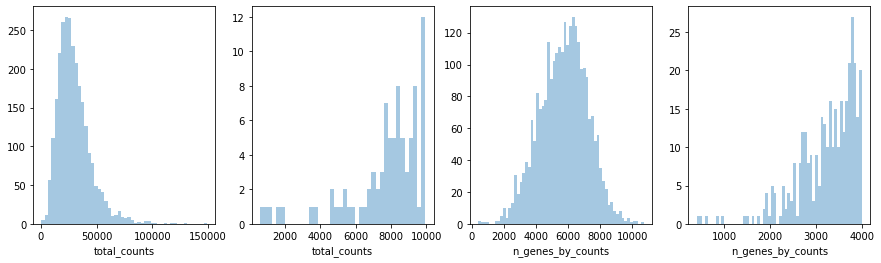

In [2]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

data looks fine, no thresholding needed for now.
Normalize data.

In [3]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

calculate gene-space clustering

In [4]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters_genes")

/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Calculate features + feature-space clustering

Below an example of the most basic feature calculation with out crop of feature optimization is demonstrated, followed by an example optimizing over crop configurations and using all features.

## Example of basic feature calculation and clustering
The available feature in the current version are: "hog", "texture", "summary", "color_hist"

In [7]:
features = features=["hog", "texture", "summary", "color_hist"]

### Write table in adata.obsm

Adding the most basic feauture, summary statistics, for clusting genes using spatial features. 

In [8]:
calculate_image_features(adata, img, ['summary'], key='features')

show first rows of features table

In [9]:
adata.obsm['features'].head()

summary_quantile_0.9_ch_0  summary_quantile_0.5_ch_0  \
obs_id                                                                     
AAACAAGTATCTCCCA-1                      132.0                      111.0   
AAACAATCTACTAGCA-1                      141.0                      111.0   
AAACACCAATAACTGC-1                      132.0                      116.0   
AAACAGAGCGACTCCT-1                      136.0                      116.0   
AAACCGGGTAGGTACC-1                      136.1                      112.0   

                    summary_quantile_0.1_ch_0  summary_quantile_0.9_ch_1  \
obs_id                                                                     
AAACAAGTATCTCCCA-1                       77.0                      102.0   
AAACAATCTACTAGCA-1                       80.0                       87.0   
AAACACCAATAACTGC-1                       90.0                      109.0   
AAACAGAGCGACTCCT-1                       93.0                      115.0   
AAACCGGGTAGGTACC-1                       83.0                      103.0   

                    summary_quantile_0.5_ch_1  summary_quantile_0.1_ch_1  \
obs_id                                                                     
AAACAAGTATCTCCCA-1                       79.0                       54.0   
AAACAATCTACTAGCA-1                       60.0                       39.0   
AAACACCAATAACTGC-1                       91.0                       67.0   
AAACAGAGCGACTCCT-1                       82.0                       58.0   
AAACCGGGTAGGTACC-1                       78.0                       54.0   

                    summary_quantile_0.9_ch_2  summary_quantile_0.5_ch_2  \
obs_id                                                                     
AAACAAGTATCTCCCA-1                      138.0                      111.0   
AAACAATCTACTAGCA-1                      135.0                      108.0   
AAACACCAATAACTGC-1                      130.0                      117.0   
AAACAGAGCGACTCCT-1                      137.0                      113.0   
AAACCGGGTAGGTACC-1                      133.0                      113.0   

                    summary_quantile_0.1_ch_2  
obs_id                                         
AAACAAGTATCTCCCA-1                       88.0  
AAACAATCTACTAGCA-1                       84.0  
AAACACCAATAACTGC-1                       98.0  
AAACAGAGCGACTCCT-1                       89.0  
AAACCGGGTAGGTACC-1                       92.0

#### Cluster genes based on gener expression and spatial features

Below we visualually compare clusterings based on the image features with gene space clusterings.

/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


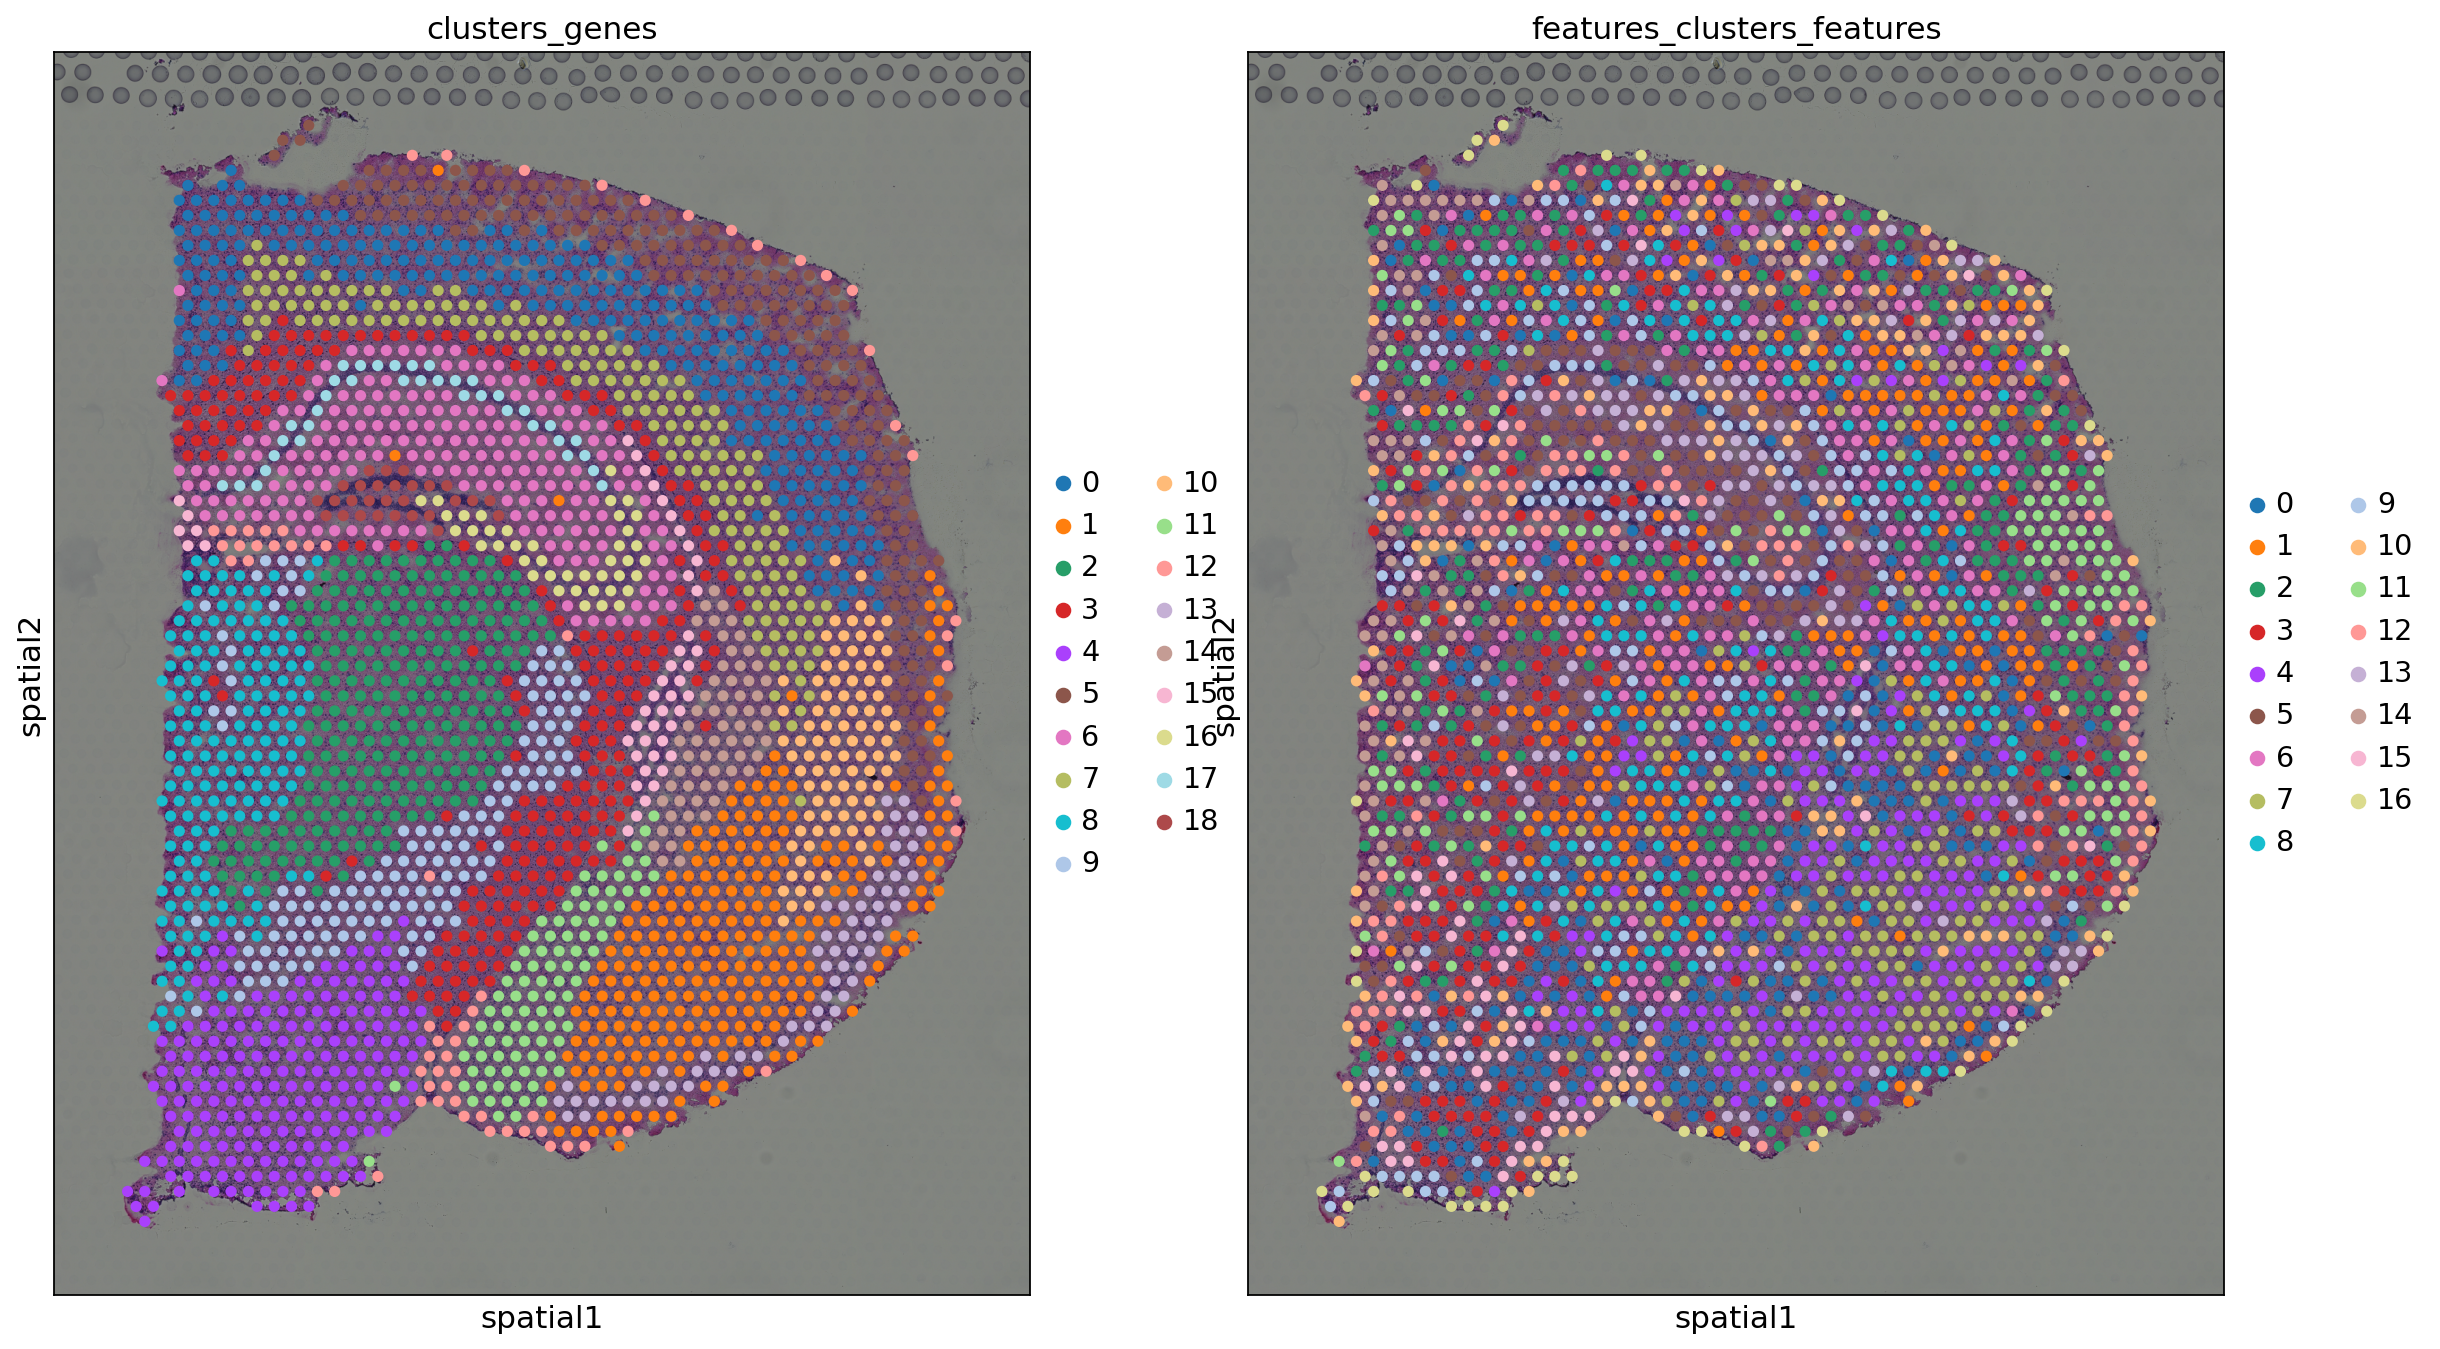

In [11]:
def cluster_features(adata, feature_name="features"):
    '''
    adata: scanpy adata object
    feature_name: str with all crop settings
    '''
    adata.obsm[feature_name + "_pca"] = sc.pp.pca(adata.obsm[feature_name])
    sc.pp.neighbors(adata, use_rep=feature_name + "_pca")
    adata.obsm[feature_name + '_umap'] = sc.tl.umap(adata, copy=True).obsm['X_umap']
    sc.tl.leiden(adata, key_added=feature_name + '_clusters_features')
    
cluster_features(adata, feature_name="features")

sc.set_figure_params(facecolor="white", figsize=(8, 15))
sc.pl.spatial(adata, color=['clusters_genes', 'features_clusters_features'], save='clustering_comparison.png')

#### Perform numerical cluster evaluation using the  Silhouette score

Between -1 and 1, 1 means most compact and different clusters

In [12]:
s = sklearn.metrics.silhouette_score(adata.obsm['X_pca'], adata.obs['clusters_genes'])
print(f"Silhouette score of gene-space clusters: {s}")

s = sklearn.metrics.silhouette_score(adata.obsm['features_pca'], adata.obs['features_clusters_features'])
print(f"Silhouette score of feature-space clusters: {s}")

Silhouette score of gene-space clusters: 0.16379119455814362
Silhouette score of feature-space clusters: 0.12226734310388565


## Run evaluation for multiple features and cropping settings

Now one can evaluate different Silhouette scores for different crop settings and features. Below all features are calculated for different crop settins.

In [ ]:
from tqdm import tqdm

# define feature and crop combinations
crop_parameters = {"sizef": [1, 1.5, 2], "scalef": [1, 0.5, 0.25], "mask_circle": [False, True]}
features = features=["hog", "texture", "summary", "color_hist"]

combinations = it.product(*(crop_parameters[Name] for Name in crop_parameters))

iter_log = {}
for combination in tqdm(list(combinations)):
    sizef, scalef, mask_circle = combination
    
    feature_name = f"image_features_size-{sizef}_scale{scalef}_circle-{mask_circle}"

    calculate_image_features(adata, img, features, key='features', sizef = sizef, scalef = scalef, 
                             mask_circle = mask_circle)
    
    cluster_features(adata, feature_name="features")
    
    s = sklearn.metrics.silhouette_score(adata.obsm['features_pca'], adata.obs['features_clusters_features'])
    
    iter_log[feature_name] = s
    print(f"Silhoutte score is for {feature_name}: {s}: ")

    

  0%|          | 0/18 [00:00<?, ?it/s]/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
  6%|▌         | 1/18 [02:04<35:21, 124.77s/it]

Silhoutte score is for image_features_size-1_scale1_circle-False: 0.09002367407083511: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 11%|█         | 2/18 [04:12<33:29, 125.57s/it]

Silhoutte score is for image_features_size-1_scale1_circle-True: 0.10603736340999603: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 17%|█▋        | 3/18 [06:20<31:37, 126.48s/it]

Silhoutte score is for image_features_size-1_scale0.5_circle-False: 0.09002367407083511: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 22%|██▏       | 4/18 [08:32<29:50, 127.90s/it]

Silhoutte score is for image_features_size-1_scale0.5_circle-True: 0.10603736340999603: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 28%|██▊       | 5/18 [10:41<27:47, 128.27s/it]

Silhoutte score is for image_features_size-1_scale0.25_circle-False: 0.09002367407083511: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 33%|███▎      | 6/18 [12:51<25:46, 128.87s/it]

Silhoutte score is for image_features_size-1_scale0.25_circle-True: 0.10603736340999603: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 39%|███▉      | 7/18 [16:10<27:29, 149.97s/it]

Silhoutte score is for image_features_size-1.5_scale1_circle-False: 0.09159349650144577: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 44%|████▍     | 8/18 [19:32<27:34, 165.44s/it]

Silhoutte score is for image_features_size-1.5_scale1_circle-True: 0.10233443975448608: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 50%|█████     | 9/18 [22:55<26:32, 176.94s/it]

Silhoutte score is for image_features_size-1.5_scale0.5_circle-False: 0.09159349650144577: 


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 56%|█████▌    | 10/18 [26:20<24:42, 185.32s/it]

Silhoutte score is for image_features_size-1.5_scale0.5_circle-True: 0.10233443975448608: 


#### See which setting configuration generated the highest Silhouette score

In [14]:
iter_log

{'image_features_size-1_scale1_circle-False': 0.12226734,
 'image_features_size-1_scale1_circle-True': 0.13063212,
 'image_features_size-1_scale0.5_circle-False': 0.12226734,
 'image_features_size-1_scale0.5_circle-True': 0.13063212,
 'image_features_size-1_scale0.25_circle-False': 0.12226734,
 'image_features_size-1_scale0.25_circle-True': 0.13063212,
 'image_features_size-1.5_scale1_circle-False': 0.10924454,
 'image_features_size-1.5_scale1_circle-True': 0.122328684,
 'image_features_size-1.5_scale0.5_circle-False': 0.10924454,
 'image_features_size-1.5_scale0.5_circle-True': 0.122328684,
 'image_features_size-1.5_scale0.25_circle-False': 0.10924454,
 'image_features_size-1.5_scale0.25_circle-True': 0.122328684,
 'image_features_size-2_scale1_circle-False': 0.110406175,
 'image_features_size-2_scale1_circle-True': 0.12647524,
 'image_features_size-2_scale0.5_circle-False': 0.110406175,
 'image_features_size-2_scale0.5_circle-True': 0.12647524,
 'image_features_size-2_scale0.25_circl

#### Compare feature based and gene based clusterings for optimal setting

Optimal features are: image_features_size: 1, scale: 1 circle: True

/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


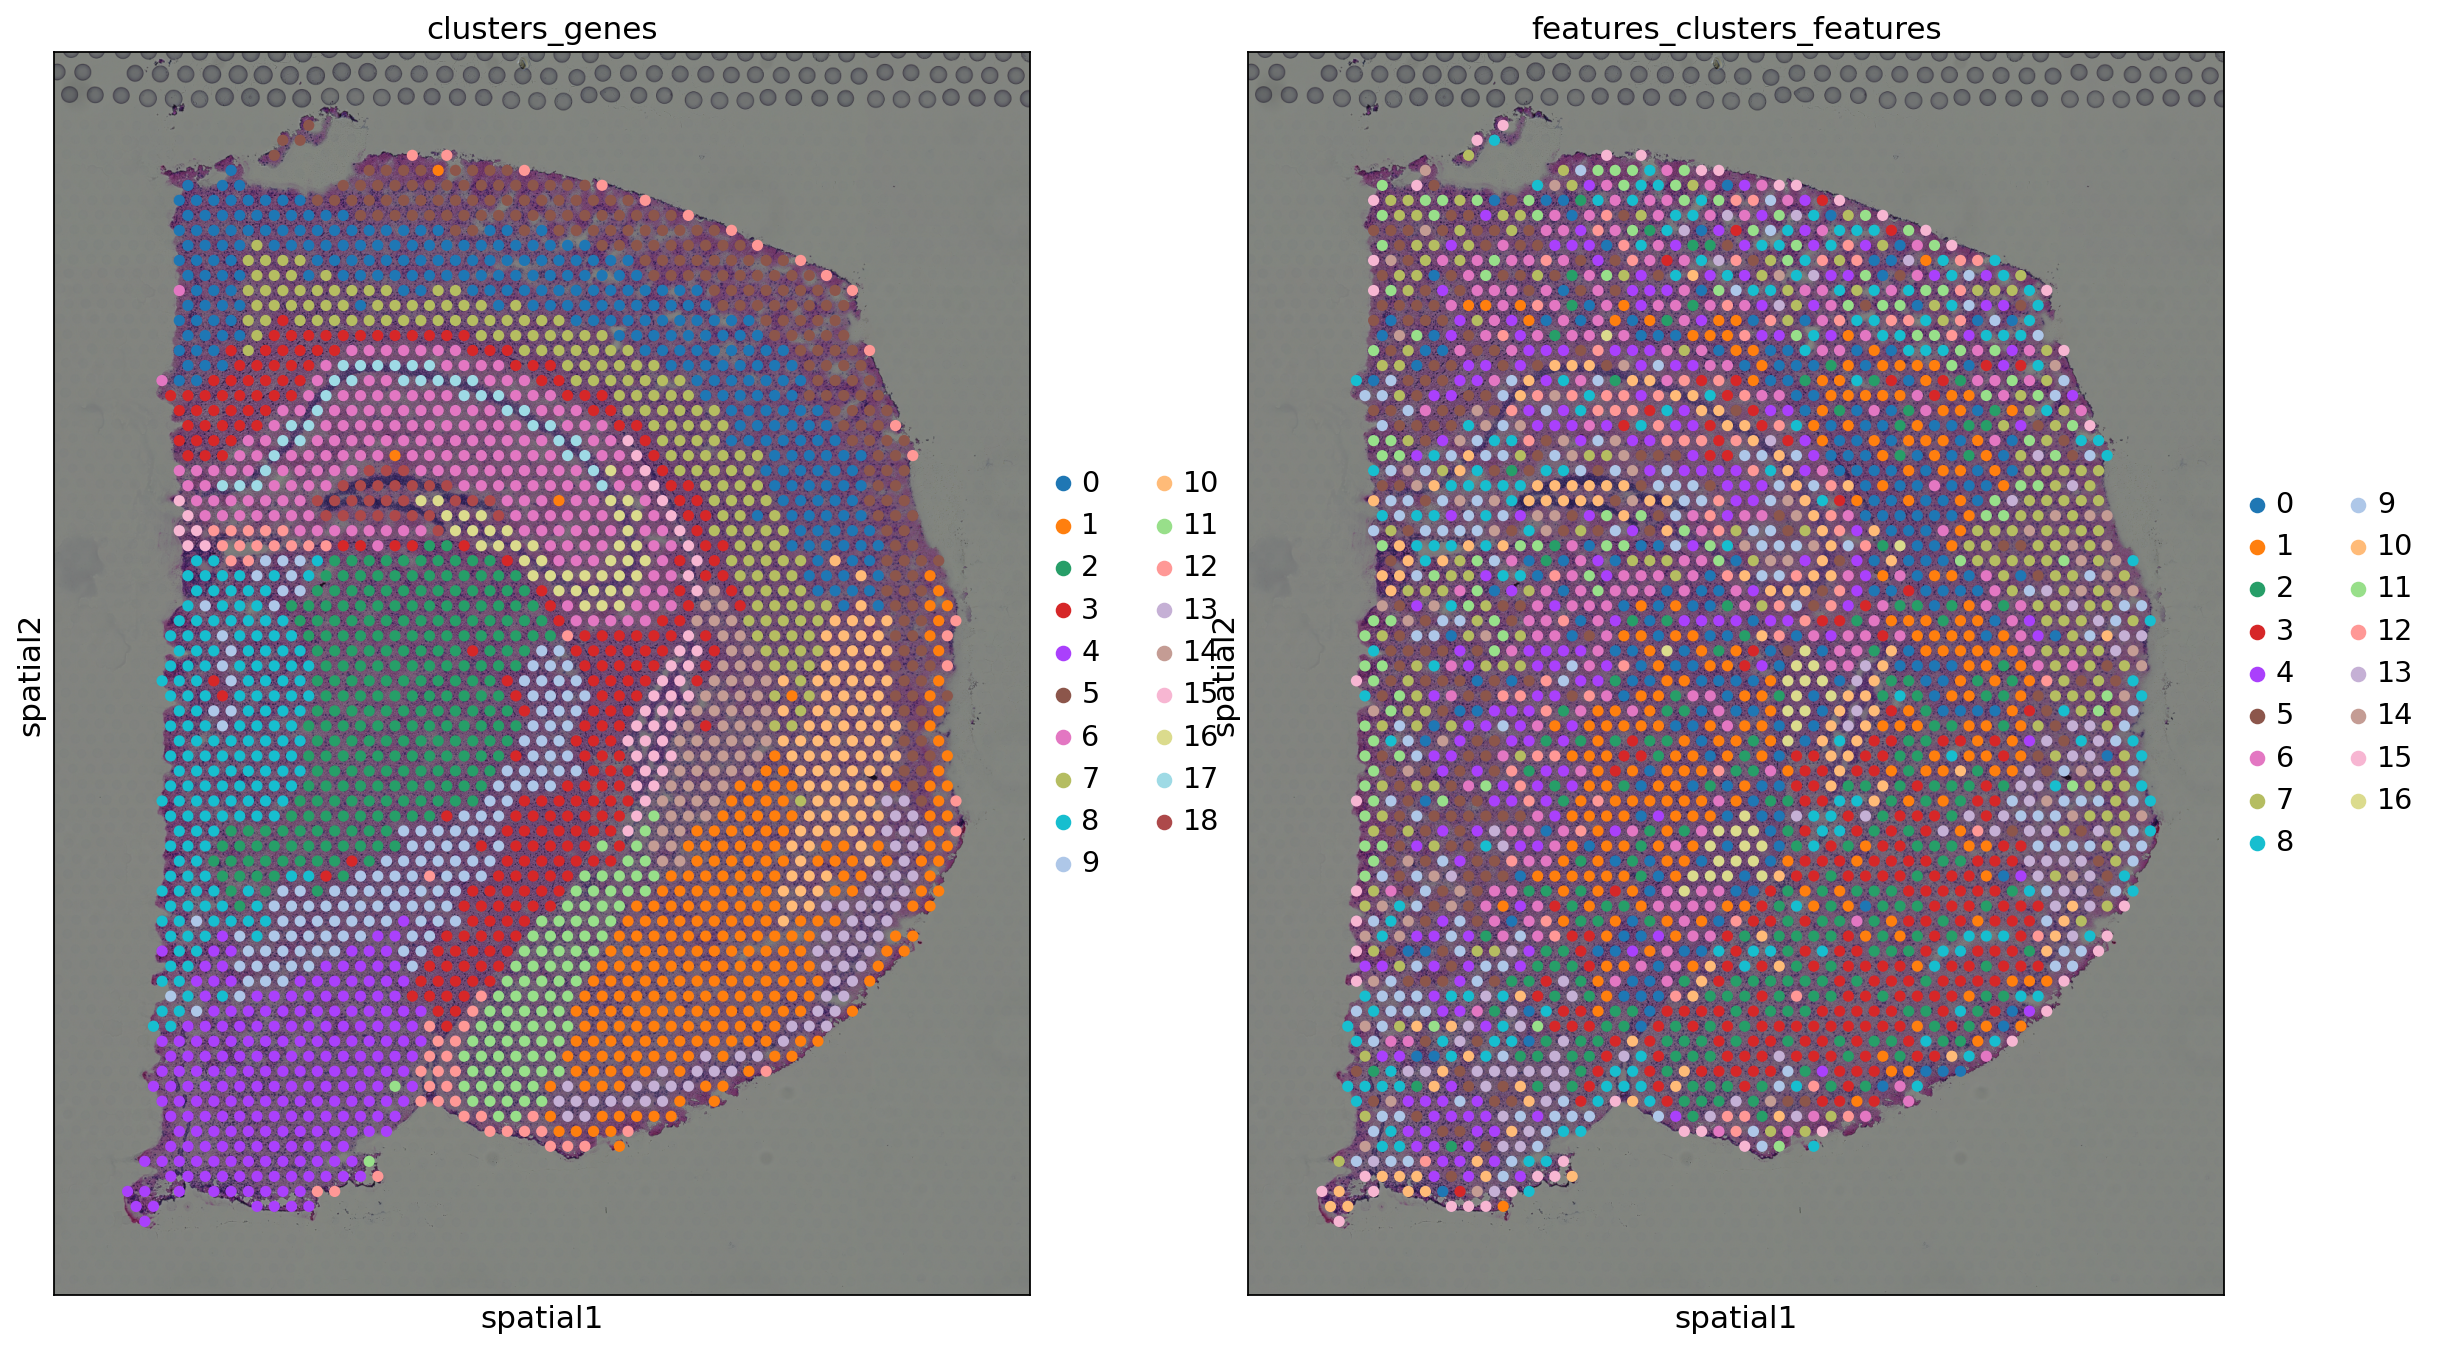

In [15]:
calculate_image_features(adata, img, features, key='features', sizef = 1, scalef = 1, 
                             mask_circle = True)


cluster_features(adata, feature_name="features")

sc.set_figure_params(facecolor="white", figsize=(8, 15))
sc.pl.spatial(adata, color=['clusters_genes', 'features_clusters_features'], save='clustering_comparison.png')